# Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import cv2

import os
from pathlib import Path

import math
from tqdm.auto import tqdm

HOME = Path.cwd().parent
BASE_DIR = HOME / 'data/raw' # Local
# BASE_DIR = Path('/content/') # Colab
TRAIN_DIR = BASE_DIR / 'train/train'
TEST_DIR = BASE_DIR / 'test/test'


# Dataset

In [2]:
# if not os.path.exists(BASE_DIR / 'kddbr-2022.zip'):
#     !gdown 1EkCNnDSbkmh2lmaiC39cj6Qsgid_wMki
#     !unzip -q kddbr-2022.zip

# First look

In [3]:
public_df = pd.read_csv(BASE_DIR / 'public.csv')
print(public_df.shape)
public_df.head()

(146262, 6)


,Filename,Altitude,Delta,North,East,kfold
0,00003e3b9e5336685200ae85d21b4f5e.jpg,178.829834,-0.065231,-0.386045,0.929772,0
1,0001261e2060303a06ba6c64d676d639.jpg,207.921478,-0.080688,0.635584,0.152819,2
2,0002ac0d783338cfeab0b2bdbd872cda.jpg,178.048431,0.021576,-1.228229,-0.499388,3
3,0004289ee1c7b8b08c77e19878106ae3.jpg,201.084625,0.505981,-1.739709,-0.699928,1
4,0004d0b59e19461ff126e3a08a814c33.jpg,187.550201,-0.328156,-0.169798,2.828752,0


In [4]:
train_df = public_df.loc[~public_df.North.isna()].copy()
print(train_df.shape)
train_df.head()

(91231, 6)


,Filename,Altitude,Delta,North,East,kfold
0,00003e3b9e5336685200ae85d21b4f5e.jpg,178.829834,-0.065231,-0.386045,0.929772,0
1,0001261e2060303a06ba6c64d676d639.jpg,207.921478,-0.080688,0.635584,0.152819,2
2,0002ac0d783338cfeab0b2bdbd872cda.jpg,178.048431,0.021576,-1.228229,-0.499388,3
3,0004289ee1c7b8b08c77e19878106ae3.jpg,201.084625,0.505981,-1.739709,-0.699928,1
4,0004d0b59e19461ff126e3a08a814c33.jpg,187.550201,-0.328156,-0.169798,2.828752,0


In [5]:
test_df = public_df.loc[public_df.North.isna()].copy()
test_df.drop(['North', 'East'], axis=1, inplace=True)
print(test_df.shape)
test_df.head()

(55031, 4)


,Filename,Altitude,Delta,kfold
91231,000053b1e684c9e7ea73727b2238ce18.jpg,167.943069,0.010269,0
91232,00029153d12ae1c9abe59c17ff2e0895.jpg,195.853088,0.089218,2
91233,0006246bee639c7a7b11a08e34dd3cc6.jpg,146.943466,-0.018326,1
91234,00063cb5da1826febf178b669eea3250.jpg,213.184418,-0.108704,1
91235,00063ece2e68a8847f228e8fd922f851.jpg,184.757767,0.017700,0


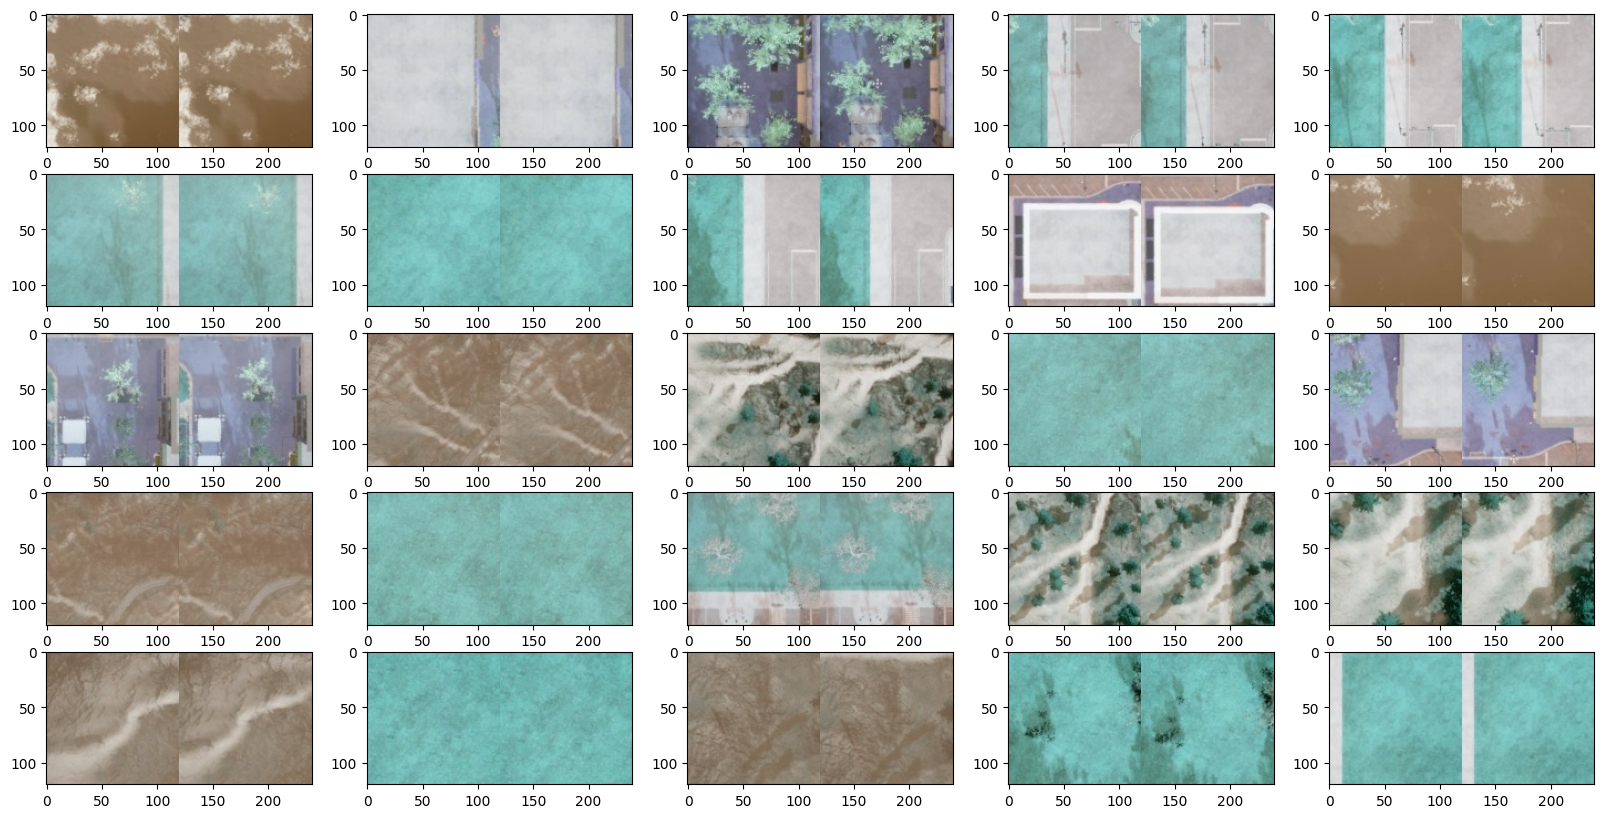

In [6]:
def plot_images(folder, rows, columns):
    files = os.listdir(folder)
    fig, axs = plt.subplots(rows, columns, figsize=(columns*4,rows*2))
    imgs = [cv2.imread(str(folder) + "/" + file) for file in np.random.choice(files, size=len(fig.axes), replace=False)]
    for i, ax in enumerate(fig.axes):
        ax.imshow(imgs[i])

plot_images(TRAIN_DIR, 5, 5)

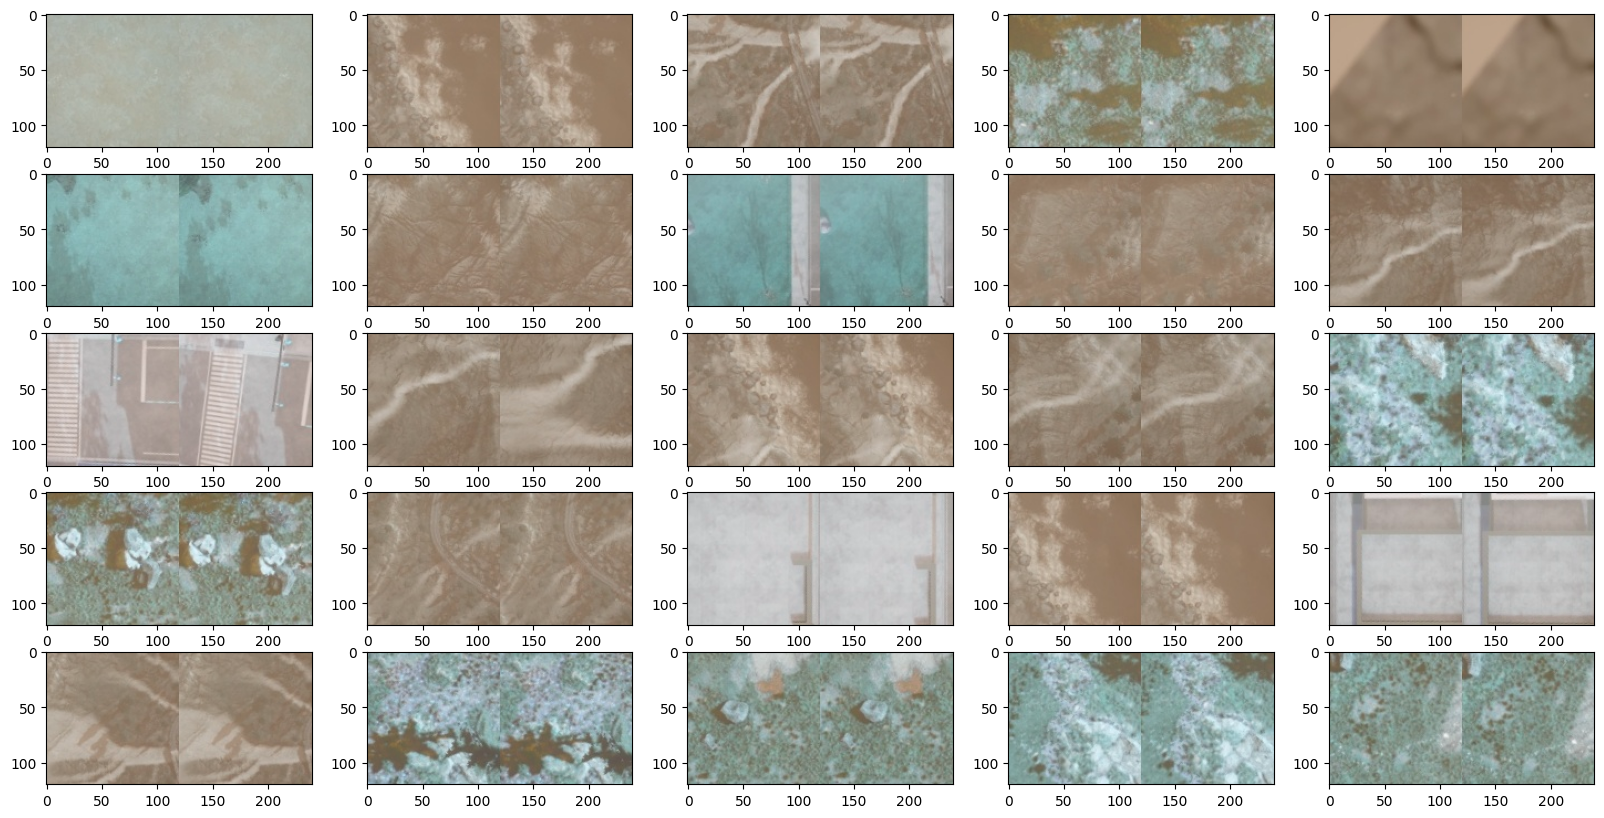

In [7]:
plot_images(TEST_DIR, 5, 5)

# Preprocessing

In [8]:
def split_convert(folder, files, out_folder=None, conversion=cv2.COLOR_RGB2GRAY):
    n_imgs = len(files)
    img_arr = np.zeros((n_imgs, 2, 120, 120), dtype='uint8')
    for m, img_file in enumerate(files):
        file_path = str(folder / img_file)
        img_rgb = cv2.imread(file_path)
        img_gray = cv2.cvtColor(img_rgb, conversion)
        img_gray_A = img_gray[:, :120]
        img_gray_B = img_gray[:, 120:]
        img_arr[m, 0] = img_gray_A
        img_arr[m, 1] = img_gray_B
    
    return img_arr

def make_imgs_arrays(img_names, dataset):
    filename = dataset + '_imgs.npy'
    if not os.path.exists(BASE_DIR / filename):
        imgs_arr = split_convert(BASE_DIR / dataset / dataset, img_names)
        np.save(BASE_DIR / filename, imgs_arr)
    else:
        imgs_arr = np.load(BASE_DIR / filename)
        
    return imgs_arr

train_imgs = make_imgs_arrays(train_df.Filename.values.tolist(), 'train')
test_imgs = make_imgs_arrays(test_df.Filename.values.tolist(), 'test')

# Extract and Match

In [9]:
extractors = {
    'AKAZE':cv2.AKAZE_create(),
    'SIFT':cv2.SIFT_create(),
    'BRISK':cv2.BRISK_create(),
    # 'ORB':cv2.ORB_create(),
}

matchers = {
    'FLANN':cv2.FlannBasedMatcher(),
    'BRUTE':cv2.BFMatcher()
}

def extract_and_match(img0, img1, extractor_name='AKAZE', matcher_name='BRUTE', max_distance=0.7, min_points=4, draw=False):

    extractor = extractors[extractor_name]
    matcher = matchers[matcher_name]

    pts0, des0 = extractor.detectAndCompute(img0, mask=None)
    pts1, des1 = extractor.detectAndCompute(img1, mask=None)

    if len(pts0) > min_points and len(pts1) > min_points:
        try:
            matches = matcher.knnMatch(des0, des1, 2)
        except:
            matches = None
            
        if matches is not None and len(matches) > 4:
            mask = [[0,0] for i in range(len(matches))]
            good_matches = []
            try:
                for i,(m,n) in enumerate(matches):
                    if m.distance < max_distance * n.distance:
                        mask[i]=[1,0]
                        good_matches.append(m)
            except:
                None
            if draw:
                draw_params = dict(matchColor=(0,255,0),
                                   singlePointColor=(255,0,0),
                                   matchesMask=mask,
                                   flags=cv2.DrawMatchesFlags_DEFAULT)

                img = cv2.drawMatchesKnn(img0, pts0, img1, pts1, matches, None, **draw_params)
                plt.imshow(img,),plt.show()

        else:
            good_matches = None
            mask = None
            # print('No matches!!!')

    else:
        matches = None
        good_matches = None
        mask = None
        # print('No minimum points!!!')

    return pts0, des0, pts1, des1, matches, good_matches, mask

In [10]:
train_df[train_df.Filename=='0a02efa28a78402c1c50322970cc2728.jpg']

,Filename,Altitude,Delta,North,East,kfold
3623,0a02efa28a78402c1c50322970cc2728.jpg,185.416534,0.052567,0.356098,-0.812848,1


In [11]:
i = 3623
img0 = train_imgs[i, 0]
img1 = train_imgs[i, 1]

pts0, des0, pts1, des1, matches, good_matches, mask = extract_and_match(img0,
                                                                        img1,
                                                                        'AKAZE',
                                                                        'BRUTE',
                                                                        0.9,
                                                                        True)

# Find homography

In [12]:
methods = {
    'NAIVE':0, # Least squares
    'RANSAC':cv2.RANSAC,
    'LMEDS':cv2.LMEDS,
    'RHO':cv2.RHO
}

def find_homography(pts0, pts1, good_matches, method_name='RANSAC', confidence=0.99, draw=False):
    method = methods[method_name]
    src_pts = [pts0[m.queryIdx] for m in good_matches]
    dst_pts = [pts1[m.trainIdx] for m in good_matches]

    src_pts_arr = np.float32([pts.pt for pts in src_pts]).reshape(-1,1,2)
    dst_pts_arr = np.float32([pts.pt for pts in dst_pts]).reshape(-1,1,2)

    M, mask = cv2.findHomography(src_pts_arr,
                                 dst_pts_arr,
                                 method=method,
                                 confidence=confidence)

    if draw:
        matchesMask = mask.ravel().tolist()
        draw_params = dict(matchColor=(0,255,0),
                           singlePointColor=(255,0,0),
                           matchesMask=matchesMask,
                           flags=cv2.DrawMatchesFlags_DEFAULT)
            
        img = cv2.drawMatches(img0, pts0, img1, pts1, good_matches, None, **draw_params)
        plt.imshow(img,),plt.show()

    #### Tentar melhorar para desenhar apenas os pontos que estao no good_matches

    return M, mask


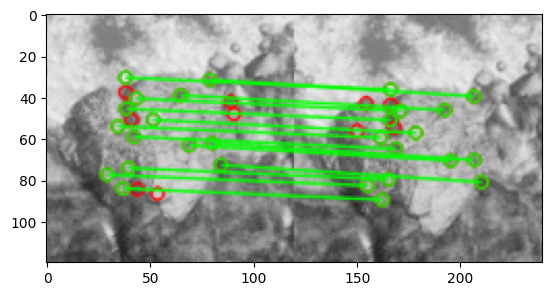

In [13]:
H, mask = find_homography(pts0, pts1, good_matches, 'RANSAC', 0.99, draw=True)

In [14]:
def get_north_east(normalised_homography):

    # a = normalised_homography[0, 0]
    # b = normalised_homography[0, 1]
    c = normalised_homography[0, 2]
    # d = normalised_homography[1, 0]
    # e = normalised_homography[1, 1]
    f = normalised_homography[1, 2]

    # p = math.sqrt(a * a + b * b)
    # r = (a * e - b * d) / (p)
    # q = (a * d + b * e) / (a * e - b * d)

    translation = (c, f)
    # scale = (p, r)
    # shear = q
    # theta = math.atan2(b, a)

    north = translation[1]
    east = translation[0] * -1

    return north, east

get_north_east(H)


(4.740282759796251, -11.067799467555353)

In [15]:
train_df[train_df.Filename=='0a02efa28a78402c1c50322970cc2728.jpg']

,Filename,Altitude,Delta,North,East,kfold
3623,0a02efa28a78402c1c50322970cc2728.jpg,185.416534,0.052567,0.356098,-0.812848,1


# Experiments


In [16]:
# print('Extractor: {} | Matcher: {} | Image: {} {}'.format(extractor_name,
#                                                             matcher_name,
#                                                             i,
#                                                             train_df.iloc[i]['Filename']))

In [17]:
def run_experiments(imgs, img_names, dataset):

    for extractor_name in tqdm(extractors.keys()):
        for matcher_name in tqdm(matchers.keys()):
            for method_name in tqdm(methods.keys()):
                if not (extractor_name == 'AKAZE' and matcher_name == 'FLANN') and \
                   not (extractor_name == 'BRISK' and matcher_name == 'FLANN'):
                    experiment = '{}_{}_{}'.format(extractor_name, matcher_name, method_name)
                    # print(experiment)
                    north_pxl = []
                    east_pxl = []
                    for i in tqdm(range(imgs.shape[0]), desc=experiment):
                        img0 = imgs[i, 0]
                        img1 = imgs[i, 1]

                        pts0, _, pts1, _, _, good_matches, _ = extract_and_match(img0,
                                                                                img1,
                                                                                extractor_name,
                                                                                matcher_name,
                                                                                0.75,
                                                                                False)         

                        if good_matches is not None and len(good_matches)>4:
                            H, _ = find_homography(pts0, pts1, good_matches, method_name, 0.9, draw=False)
                            if H is not None:
                                north, east = get_north_east(H)
                            else:
                                north, east = None, None
                        else:
                            north, east = None, None

                        north_pxl.append(north)
                        east_pxl.append(east)

                    df = pd.DataFrame({'Images':img_names, 'North_pixel':north_pxl, 'East_pixel':east_pxl})
                    filename = 'pixels_dist_' + dataset + '_' + experiment + '.csv'
                    df.to_csv(BASE_DIR /filename, index=False)


# run_experiments(train_imgs, train_df.Filename.values.tolist(), 'train')
run_experiments(test_imgs, test_df.Filename.values.tolist(), 'test')


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

AKAZE_BRUTE_NAIVE:   0%|          | 0/55031 [00:00<?, ?it/s]

AKAZE_BRUTE_RANSAC:   0%|          | 0/55031 [00:00<?, ?it/s]

AKAZE_BRUTE_LMEDS:   0%|          | 0/55031 [00:00<?, ?it/s]

AKAZE_BRUTE_RHO:   0%|          | 0/55031 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

SIFT_FLANN_NAIVE:   0%|          | 0/55031 [00:00<?, ?it/s]

SIFT_FLANN_RANSAC:   0%|          | 0/55031 [00:00<?, ?it/s]

SIFT_FLANN_LMEDS:   0%|          | 0/55031 [00:00<?, ?it/s]

SIFT_FLANN_RHO:   0%|          | 0/55031 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

SIFT_BRUTE_NAIVE:   0%|          | 0/55031 [00:00<?, ?it/s]

SIFT_BRUTE_RANSAC:   0%|          | 0/55031 [00:00<?, ?it/s]

SIFT_BRUTE_LMEDS:   0%|          | 0/55031 [00:00<?, ?it/s]

SIFT_BRUTE_RHO:   0%|          | 0/55031 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

BRISK_BRUTE_NAIVE:   0%|          | 0/55031 [00:00<?, ?it/s]

BRISK_BRUTE_RANSAC:   0%|          | 0/55031 [00:00<?, ?it/s]

BRISK_BRUTE_LMEDS:   0%|          | 0/55031 [00:00<?, ?it/s]

BRISK_BRUTE_RHO:   0%|          | 0/55031 [00:00<?, ?it/s]